# Wavelet Significance Testing Methods Development

This is the development notebook of the significance testing using wavelet analysis. I am using this notebook to:

1) Guide the implementation of cwt

2) Guide significance testing of cwt. There are two general approaches to hypothesis testing/significance detection. First, is the use of Monte-Carlo simulations, which is largely what is presented in TC98. The second is understanding the analytic functions for certain classes of null hypotheses (specifically for red noise with CWT following TC98.

Additionally, each general approach will be compared to examples in literature to verify that the pycwt library and my additions to it all function in a consistent way.

Each reference is referred to by the initial of the first author and year (e.g., Ge (2008) will be G08).

### References
Allen, M. R., and L. A. Smith (1996), Monte Carlo SSA: Detecting Irregular Oscillations in the Presence of Colored Noise, J. Clim., 9, 3373–3403, doi:10.1175/1520-0442(1996)009<3373:MCSDIO>2.0.CO;2.

Chavez, M., and B. Cazelles (2019), Detecting dynamic spatial correlation patterns with generalized wavelet coherence and non-stationary surrogate data, Sci. Rep., 9(April), 1–9, doi:10.1038/s41598-019-43571-2.

Ge, Z. (2007), Significance tests for the wavelet power and the wavelet power spectrum, Ann. Geophys., 25(11), 2259–2269, doi:10.5194/angeo-25-2259-2007.

Ge, Z. (2008), Significance tests for the wavelet cross spectrum and wavelet linear coherence, Ann. Geophys., 26(2007), 3819–3829, doi:10.5194/angeo-26-3819-2008.

Gilman, D. L., F. J. Fuglister, and J. J. M. Mitchell (1962), On the Power Spectrum of “Red Noise,” J. Atmos. Sci., 20, 182–184, doi:1520-0469(1963)020<0182:OTPSON>2.0.CO;2.

Liu, Y., S. X. Liang, and R. H. Weisberg (2007), Rectification of the Bias in the Wavelet Power Spectrum, J. Atmos. Ocean. Technol., 24, 2093–2102, doi:10.1175/2007JTECHO511.1.

Torrence, C., and G. P. Compo (1998), A Practical Guide to Wavelet Analysis, Bull. Am. Meteorol. Soc., 79(1), 61–78, doi:https://doi.org/10.1175/1520-0477(1998)079<0061:APGTWA>2.0.CO;2.

Veleda, D., R. Montagne, and M. Araujo (2012), Cross-Wavelet Bias Corrected by Normalizing Scales, J. Atmos. Ocean. Technol., 29, 1401–1408, doi:10.1175/JTECH-D-11-00140.1.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import scipy

# OS interaction
import os
import yaml

# import plotting|
import seaborn as sns
import matplotlib.pyplot as plt
import string
import pandas as pd
import copy
import pyfocs
import pycwt
import kgraph

# Local pycwt helper functions
import pycwt_stat_helpers as cwt_stat
import pycwt_plot_helpers as cwt_plt
# My local colorbline friendly colormap generator
import SRON

/Users/karllapo/anaconda3/lib/python3.7/typing.py:850: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


# Format plots

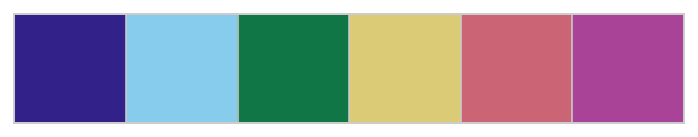

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context("paper")

# Define a default color palette (this should be fairly color blind friendly)
flatui = SRON.SRON(6)
sns.set_palette(sns.color_palette(flatui))
sns.palplot(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']
ms_list = ['v', '*', 's', 'o']

alphabet = list(string.ascii_lowercase)

# Wavelet significance testing

There are two types of significance tests: 

1) analytically derived thresholds

2) Monte-Carlo simulations

Most recent, high-impact publications using wavelets have used Monte-Carlo simulations. The analytically-derived thresholds rely on a known noise property. For CWT that known noise is usually white noise or red noise. For wavelet coherence, there have been only a couple attempts to derive analytic expressions (i.e., Ge 2008). As the implementation and innovation of wavelet applications has outpaced the analytic understanding, my impression is that the consequence has been to turn increasingly to Monte-Carlo derived significance tests. Note that the field has not really progressed past the original Monte-Carlo simulations or approximations of Monte-Carlo simulations from TC98.

In this notebook I try to provide some documentation of how I approached this general problem.

For __continuous wavelet transforms__, I will implement the following tests:

- Analytically derived signficance tests for CWT following TC98 for a red noise process described as an AR(1) Markov chain.

- Monte-Carlo simulations. Just to verify the significance spectra as a reassurance that everything is functioning correctly.


# Significance testing of the CWT

Here, I return to the toy data from L07 used in the cwt notebook.

I added a `sig_kwargs` variable to pass options to the significance testing. It is a bit clunky at the moment (i.e., the user defined signal variance and red noise coefficient, alpha, are defined in two different ways) but it allows the user to pass a value to the signficance testing function.

The signficance testing follows the functions available in pycwt, which follow TC98 for local, global, and scale averaging signficance testing. This means only testing white (alpha ~ 0) 

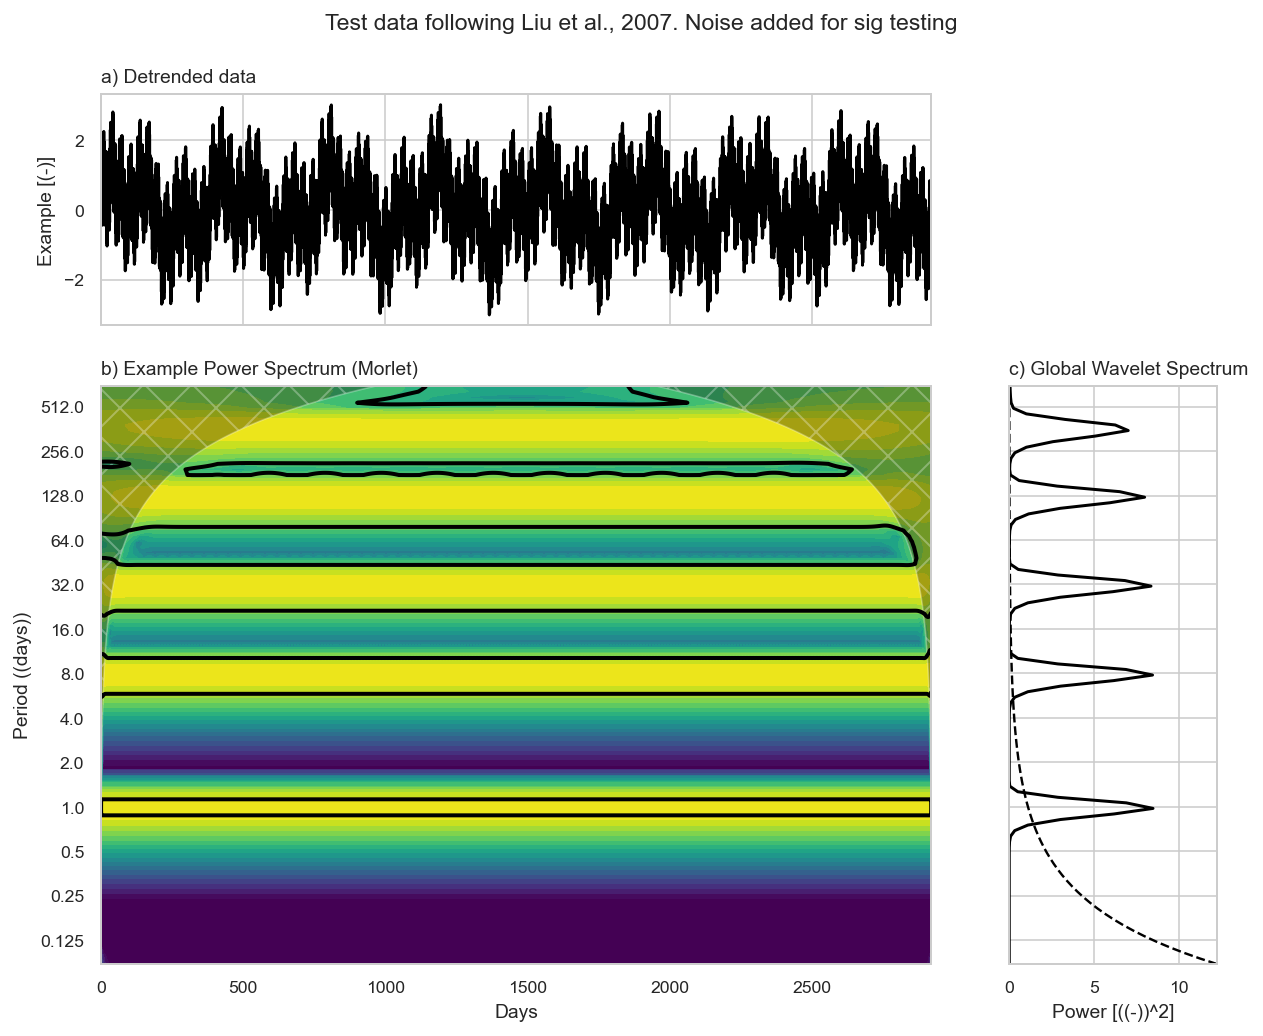

In [3]:
periods_days = np.array([1, 8, 32, 128, 365]) / 24
hours = np.arange(0, 8 * 365, 1 / 24)
signal = np.zeros_like(hours)
for p in periods_days:
    signal = signal + np.sin(hours * 2 * np.pi / (24 * p))

N = signal.size
mother = pycwt.Morlet()
# Twelve sub-octaves per octaves
# Nine powers of two with dj sub-octaves
octaves = [1 / 8, 13 / (1 / 8)]  

# Perform the CWT (note that rectify=True is the default)
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, 1/24, hours, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=True,
    norm_kwargs={'standardize': True, 'detrend': False},
    sig_kwargs={
        'alpha': 0.,
        'sig_lvl': 0.99,       
               },
)

# Create the periodogram
title = 'Test data following Liu et al., 2007. Noise added for sig testing'
label = 'Example'
units = '(-)'
scale_units = '(days)'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': 'Days'
}

cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=1/24,
    period=period,
    power=power,
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power,
    sig95=sig95,
    scale_avg=scale_avg,
    scale_avg_signif=scale_avg_signif,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

As noted in the cwt notebook, the automatic significance test incorrectly finds that the 32 day period is not significant locally but is significant globally. Here, by feeding a "more correct" value for the red noise coefficient we correctly identify each local and global peak.



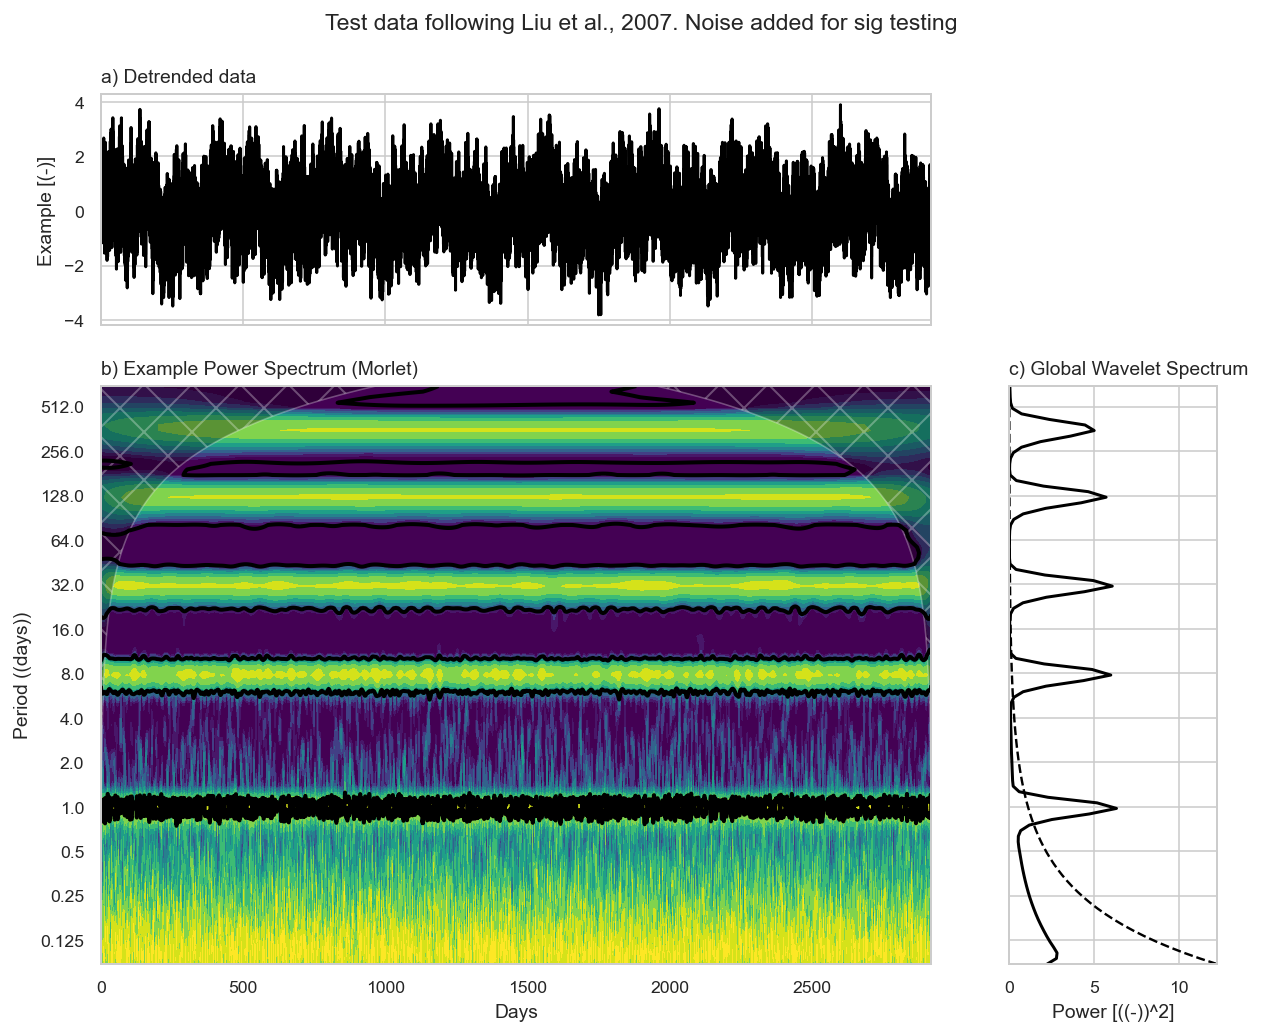

In [4]:
periods_days = np.array([1, 8, 32, 128, 365]) / 24
hours = np.arange(0, 8 * 365, 1 / 24)
signal = np.zeros_like(hours)
for p in periods_days:
    signal = signal + np.sin(hours * 2 * np.pi / (24 * p))

# Most amplitudes are size 1 and now a noisy signal is added
noise_amp = 1
signal = signal + np.random.normal(size=len(hours), scale=noise_amp)

N = signal.size
mother = pycwt.Morlet()
# Twelve sub-octaves per octaves
# Nine powers of two with dj sub-octaves
octaves = [1 / 8, 13 / (1 / 8)]  

# Perform the CWT (note that rectify=True is the default)
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, 1/24, hours, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=True,
    norm_kwargs={'standardize': True, 'detrend': False},
    sig_kwargs={
        'alpha': 0.,
        'sig_lvl': 0.99,       
               },
    variance=noise_amp ** 2
)

# Create the periodogram
title = 'Test data following Liu et al., 2007. Noise added for sig testing'
label = 'Example'
units = '(-)'
scale_units = '(days)'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': 'Days'
}

cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=1/24,
    period=period,
    power=power,
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power,
    sig95=sig95,
    scale_avg=scale_avg,
    scale_avg_signif=scale_avg_signif,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

Here the noise dominates at high frequencies and as a result the shortest deliberate signal is a bit messier. That's ok!

If I set the sig_lvl to e.g., the default value of 0.95 then a bunch of events at the highest frequencies get identified as significant. Adding this keyword was really useful.

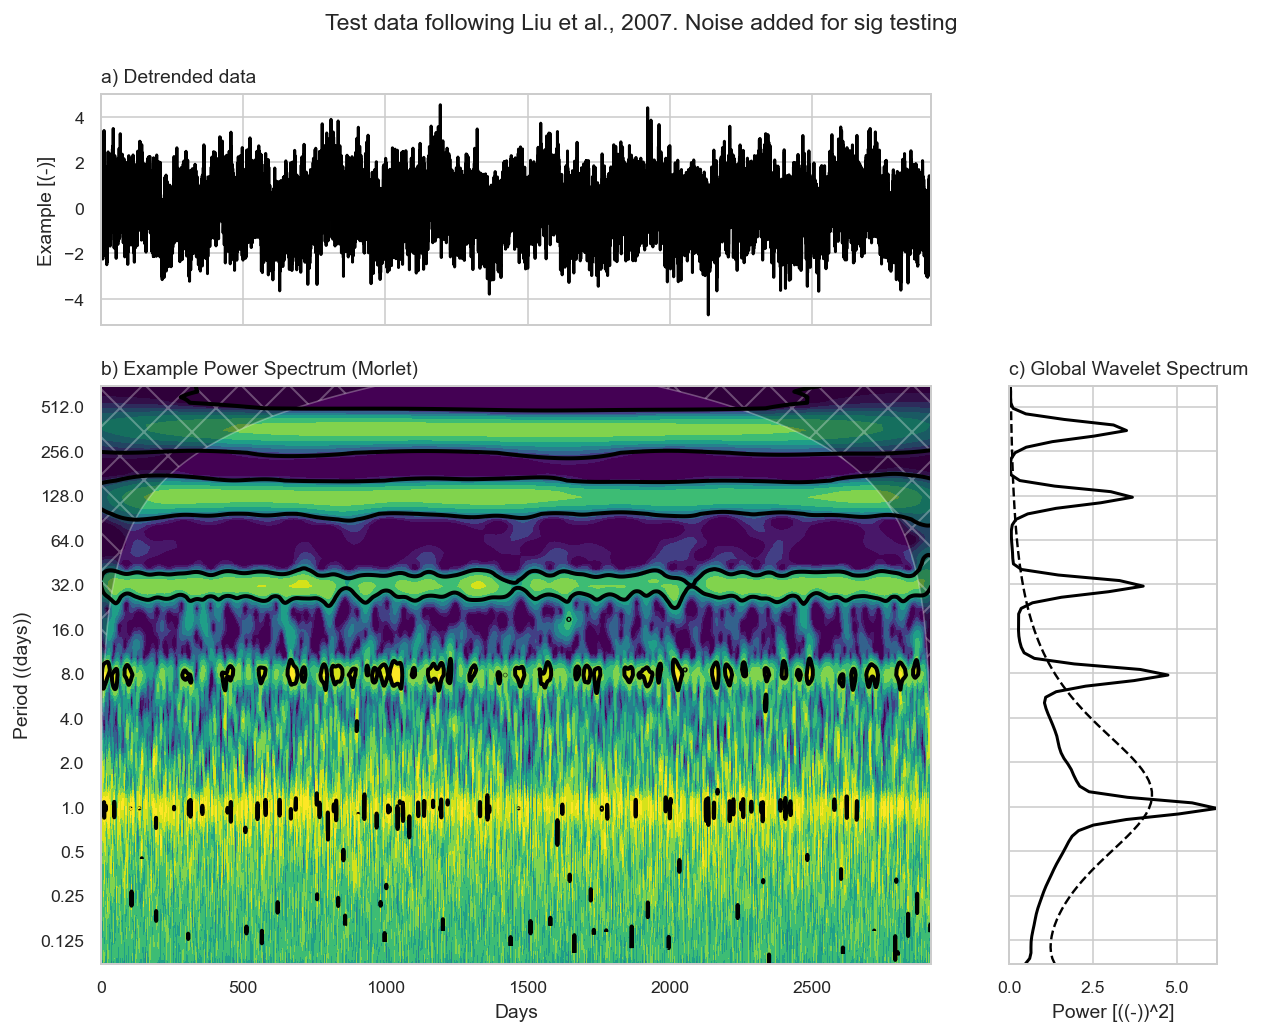

In [8]:
periods_days = np.array([1, 8, 32, 128, 365]) / 24
hours = np.arange(0, 8 * 365, 1 / 24)
signal = np.zeros_like(hours)
for p in periods_days:
    signal = signal + np.sin(hours * 2 * np.pi / (24 * p))

# Most amplitudes are size 1 and now a red noise process is added
noise_amp = 1
alpha = 0.8
signal = signal + cwt_stat.ar1_generator(len(hours), 0.8, noise_amp)

N = signal.size
mother = pycwt.Morlet()
# Twelve sub-octaves per octaves
# Nine powers of two with dj sub-octaves
octaves = [1 / 8, 13 / (1 / 8)]  

# Perform the CWT (note that rectify=True is the default)
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, 1/24, hours, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=True,
    norm_kwargs={'standardize': True, 'detrend': False},
    sig_kwargs={
        'alpha': alpha,
        'sig_lvl': 0.99,       
               },
    variance=noise_amp ** 2
)

# Create the periodogram
title = 'Test data following Liu et al., 2007. Noise added for sig testing'
label = 'Example'
units = '(-)'
scale_units = '(days)'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': 'Days'
}

cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=1/24,
    period=period,
    power=power,
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power,
    sig95=sig95,
    scale_avg=scale_avg,
    scale_avg_signif=scale_avg_signif,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

Now with adding a red noise process we see that the highest frequency oscillator is not well resolved locally, but the global power spectrum still identifies it. The slope in the underlying spectrum for the red noise process is correctly identified and removed.

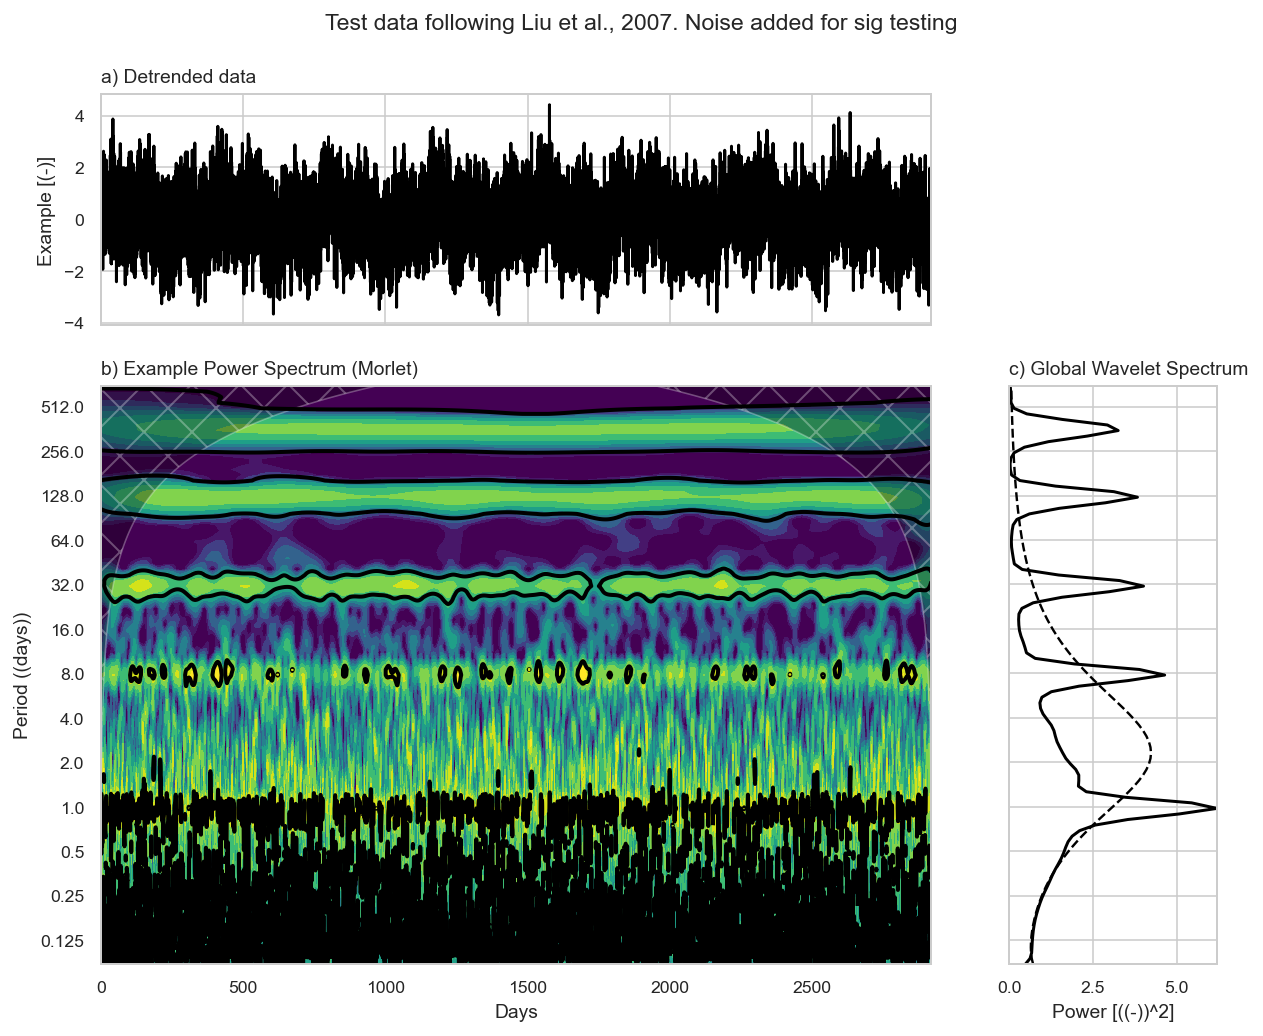

In [6]:
periods_days = np.array([1, 8, 32, 128, 365]) / 24
hours = np.arange(0, 8 * 365, 1 / 24)
signal = np.zeros_like(hours)
for p in periods_days:
    signal = signal + np.sin(hours * 2 * np.pi / (24 * p))

# Most amplitudes are size 1 and now a red noise process is added
noise_amp = 1
alpha = 0.8
signal = signal + cwt_stat.ar1_generator(len(hours), 0.8, noise_amp)

N = signal.size
mother = pycwt.Morlet()
# Twelve sub-octaves per octaves
# Nine powers of two with dj sub-octaves
octaves = [1 / 8, 13 / (1 / 8)]  

# Perform the CWT (note that rectify=True is the default)
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, 1/24, hours, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=True,
    norm_kwargs={'standardize': True, 'detrend': False},
)

# Create the periodogram
title = 'Test data following Liu et al., 2007. Noise added for sig testing'
label = 'Example'
units = '(-)'
scale_units = '(days)'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': 'Days'
}

cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=1/24,
    period=period,
    power=power,
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power,
    sig95=sig95,
    scale_avg=scale_avg,
    scale_avg_signif=scale_avg_signif,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

The significance testing without specifying the sig_kwargs using the "a priori" knowledge of the signal misses many of the salient features and particularly struggles at the highest frequencies.

# Compare to Monte-Carlo Simulations

Just a quick sanity check. First, modify the toy data to be shorter so that the Monte-Carlo simulations do not take so long.

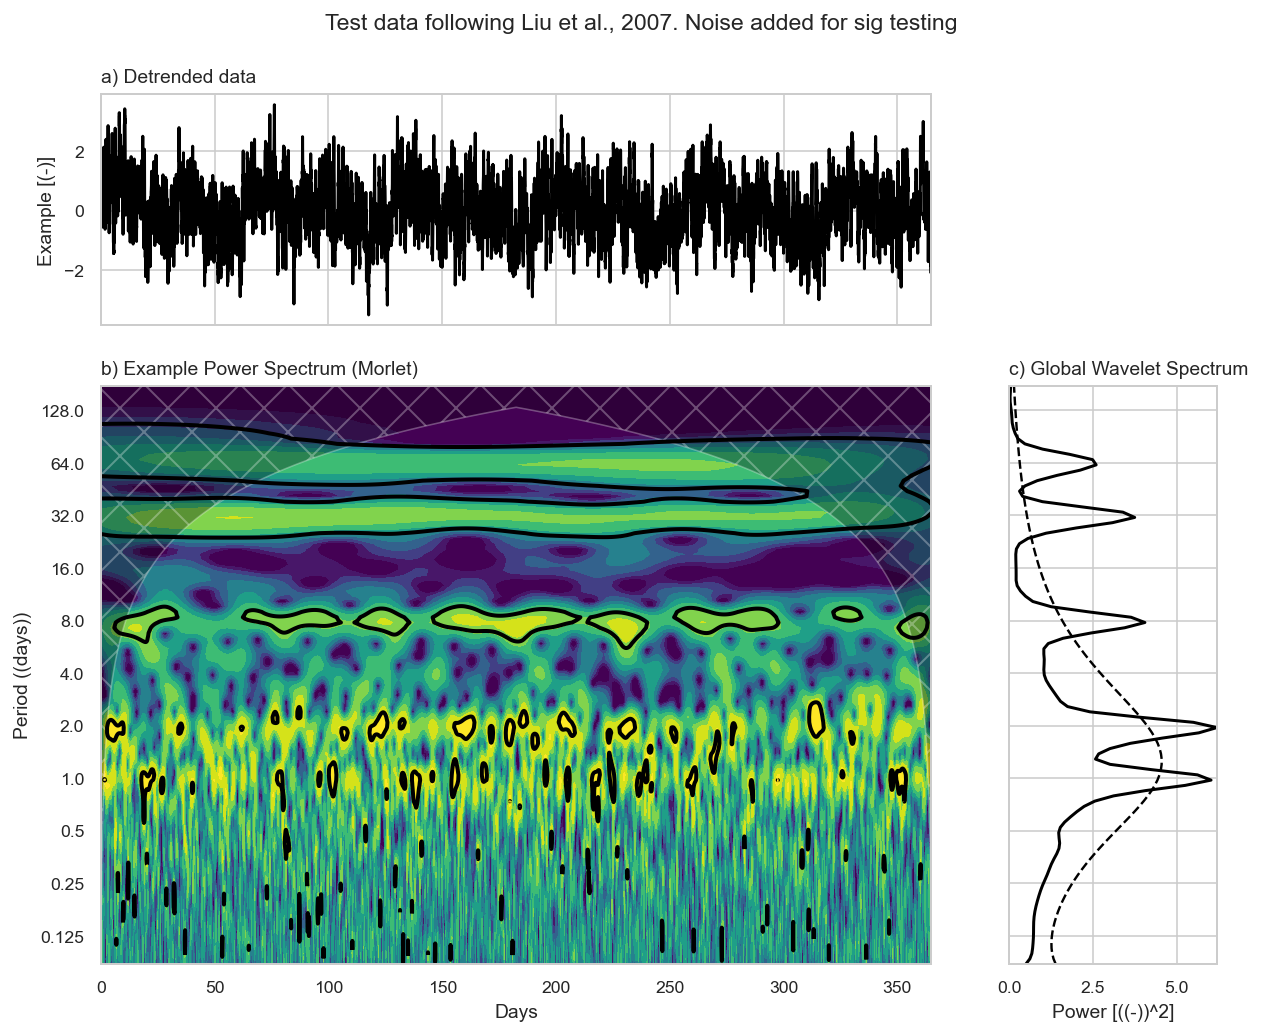

In [31]:
# Remove the longest periods and shorten.
dt = 1 / 24
periods_days = np.array([1, 2, 8, 32, 64]) * dt
hours = np.arange(0, 1 * 365, dt)
signal = np.zeros_like(hours)
for p in periods_days:
    signal = signal + np.sin(hours * 2 * np.pi / (24 * p))

# Most amplitudes are size 1 and now a red noise process is added
noise_amp = 1
alpha = 0.8
signal = signal + cwt_stat.ar1_generator(len(hours), 0.8, noise_amp)

N = signal.size
mother = pycwt.Morlet()
# Twelve sub-octaves per octaves
# Nine powers of two with dj sub-octaves
octaves = [1 / 10, 11 / (1 / 10)]  

# Perform the CWT (note that rectify=True is the default)
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, dt, hours, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=True,
    norm_kwargs={'standardize': True, 'detrend': False},
    sig_kwargs={
        'alpha': alpha,
        'sig_lvl': 0.95,       
               },
)

# Create the periodogram
title = 'Test data following Liu et al., 2007. Noise added for sig testing'
label = 'Example'
units = '(-)'
scale_units = '(days)'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': 'Days'
}

cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=dt,
    period=period,
    power=power,
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power,
    sig95=sig95,
    scale_avg=scale_avg,
    scale_avg_signif=scale_avg_signif,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

### To do:

- Run a quick Monte-Carlo to verify that the theoretical spectra are correct
- Look at the scale averaged significance testing.

In [ ]:
mc_count = 100
N = len(hours)
wavelet = mother
significance_level = 0.95
J = np.int(octaves[1])
dj = octaves[0]
dt = sampling_p
s0 = dt * 2
slen = np.int(N)

# Red noise MC
al = 0.9
noise = 1 # This is the worst case for the Ultima
sfunc_args1 = [
    alpha,
    noise_amp
]
sfunc_args2 = [
    alpha,
    noise_amp
]

coh_rn, period, scales, coi  = cwt_stat.wct_mc_sig(
    wavelet,
    J,
    dj,
    dt,
    s0,
    sfunc_args1=sfunc_args1,
    sfunc_args2=sfunc_args2,
    mc_count=mc_count,
    slen=N,
    sig_lvl=0.95,
    sfunc=ar1_generator,
)

# White noise MC
al = 0.001
sfunc_args1 = [
    al,
    noise
]
sfunc_args2 = [
    al,
    noise
]

coh_wn, period, scales, coi  = cwt_stat.wct_mc_sig(
    wavelet,
    J,
    dj,
    dt,
    s0,
    sfunc_args1=sfunc_args1,
    sfunc_args2=sfunc_args2,
    mc_count=mc_count,
    slen=N,
    sig_lvl=0.95,
    sfunc=ar1_generator,
)